In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
# from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import random

# シード値を固定
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# 🐱🐶 画像分類モデルの学習
print(Sequential)
# GPUがあるか確認して、あればメモリ制限
print(device_lib.list_local_devices())
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("✅ GPUが見つかりました")
    try:
        # 動的メモリ割り当てを有効化
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPUメモリの動的割り当てを設定しました")
    except RuntimeError as e:
        print("❌ メモリ設定に失敗しました：", e)
        
# 🟡 ここに設定をまとめておくと便利！
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 12 # 1回の学習で使う画像の枚数
EPOCHS = 50 # 「全部の画像 × 3周」を学習って感じニャ！
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)  # 画像の縦・横・チャンネル数

train_dir = 'dataset/train'
val_dir = 'dataset/validation'

# 📁 データの前処理
'''
「画像の画素値を 0〜1の範囲に正規化 するよ！」という設定にゃ！
元の画像って、1ピクセルあたり 0〜255 の値を持ってるけど
→ ニューラルネットは 小さい値の方が学習しやすいので
→ 0〜1の範囲に収めることで学習がスムーズに進むにゃ!
datagenはこれは開発者が自由に付けてる変数名だけど、
data + generator = datagen って感じで「データを生成するもの」って感じにゃ！
train_datagen → 学習用のデータを生成してくれるオブジェクト
val_datagen → 検証用の画像は変形せず、正規化だけして使うことが多いにゃ！
'''
# 訓練用ジェネレーター（オーグメンテーション付き）（回転やズームなど）をかけながら、ランダムに画像を取り出して学習させる
train_datagen = ImageDataGenerator(
    # rescale=1./255,
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    rotation_range=15,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# ディレクトリから画像を読み込む
train_generator = train_datagen.flow_from_directory(
    train_dir,  # 訓練データのパス
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=seed_value
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=seed_value # 乱数シードを固定
    # shuffle=False, # シャッフルしない場合は、Trueにするとエラーになるので注意
)

print(f"✅ 訓練データ数: {train_generator.samples}")
print(f"✅ 検証データ数: {val_generator.samples}")
print(f"✅ クラス: {train_generator.class_indices}")


<class 'keras.engine.sequential.Sequential'>
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16376804537062258685
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10063183872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6080906583266778998
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
✅ GPUが見つかりました
✅ GPUメモリの動的割り当てを設定しました
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
✅ 訓練データ数: 20000
✅ 検証データ数: 5000
✅ クラス: {'cats': 0, 'dogs': 1}


In [2]:
# 🧠 モデル構築
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# ResNet50のベースモデル（ImageNet学習済み）を使う
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 転移学習のため、ベースモデルの重みは固定する
   
# カスタム分類層を上に乗せる（改善版）
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # バッチ正規化を追加

# より深いネットワーク構造
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  # バッチ正規化を追加
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)  # バッチ正規化を追加
x = Dropout(0.4)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)  # バッチ正規化を追加
x = Dropout(0.3)(x)

predictions = Dense(1, activation='sigmoid')(x)

# モデル定義
model = Model(inputs=base_model.input, outputs=predictions)



In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ---------- 第1段階 (全凍結) ----------
model.compile(optimizer=Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks_stage1 = [
    EarlyStopping(monitor='val_accuracy', patience=10,
                  restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                      patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_stage1.h5', monitor='val_accuracy',
                    save_best_only=True, verbose=1)
]

history_1 = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks_stage1,
    verbose=1
)

# ---------- 第2段階 (Fine-tuning) ----------
# 末尾30層だけ学習させる
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5),   # lr を必ず小さく
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks_stage2 = [
    EarlyStopping(monitor='val_accuracy', patience=15,
                  restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                      patience=7, min_lr=1e-8, verbose=1),
    ModelCheckpoint('best_stage2_finetuned.h5', monitor='val_accuracy',
                    save_best_only=True, verbose=1)
]

history_2 = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks_stage2,
    verbose=1,
    initial_epoch=len(history_1.history['loss'])  # 続きから
)

# ---------- 最終モデル保存 ----------
model.save('cat_dog_final.h5')
# モデルの要約を表示
model.summary()

Epoch 1/20
1667/1667 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.9344
Epoch 1: val_accuracy improved from -inf to 0.98580, saving model to best_stage1.h5
1667/1667 [==============================] - 106s 61ms/step - loss: 0.1697 - accuracy: 0.9344 - val_loss: 0.0408 - val_accuracy: 0.9858 - lr: 1.0000e-04
Epoch 2/20
1667/1667 [==============================] - ETA: 0s - loss: 0.1076 - accuracy: 0.9610
Epoch 2: val_accuracy improved from 0.98580 to 0.98680, saving model to best_stage1.h5
1667/1667 [==============================] - 95s 57ms/step - loss: 0.1076 - accuracy: 0.9610 - val_loss: 0.0387 - val_accuracy: 0.9868 - lr: 1.0000e-04
Epoch 3/20
1667/1667 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.9644
Epoch 3: val_accuracy did not improve from 0.98680
1667/1667 [==============================] - 96s 57ms/step - loss: 0.0997 - accuracy: 0.9644 - val_loss: 0.0406 - val_accuracy: 0.9858 - lr: 1.0000e-04
Epoch 4/20
1666/1667 [=====

In [4]:
# 🧪 モデル評価
# "validation" フォルダの中にある画像を使って、モデルの評価を行うにゃ！
# ➊ 検証用ジェネレーターを作成（shuffle=False でファイル順に対応）
# 画像に手を加えずに、そのまま順番に取り出して評価する
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='binary',
    shuffle=False,                  # 検証はシャッフルしない
    seed=seed_value 
)

# ➊ モデルの評価（検証データ全体での最終的な loss と accuracy を取得）
loss_eval, acc_eval = model.evaluate(val_gen, verbose=1)
print(f"▶ 最終検証損失: {loss_eval:.4f}")
print(f"▶ 最終検証精度: {acc_eval:.4f}")
print("▶ モデルの評価が完了しましたにゃ！")

from datetime import datetime
fname = f"cat_dog_{datetime.now():%Y%m%d_%H%M}_acc{acc_eval:.2f}.h5"
model.save(fname)
print(f"モデルを {fname} に保存しました🐾")

Found 5000 images belonging to 2 classes.
5000/5000 [==============================] - 46s 9ms/step - loss: 0.0322 - accuracy: 0.9892
▶ 最終検証損失: 0.0322
▶ 最終検証精度: 0.9892
▶ モデルの評価が完了しましたにゃ！
モデルを cat_dog_20250524_2127_acc0.99.h5 に保存しました🐾


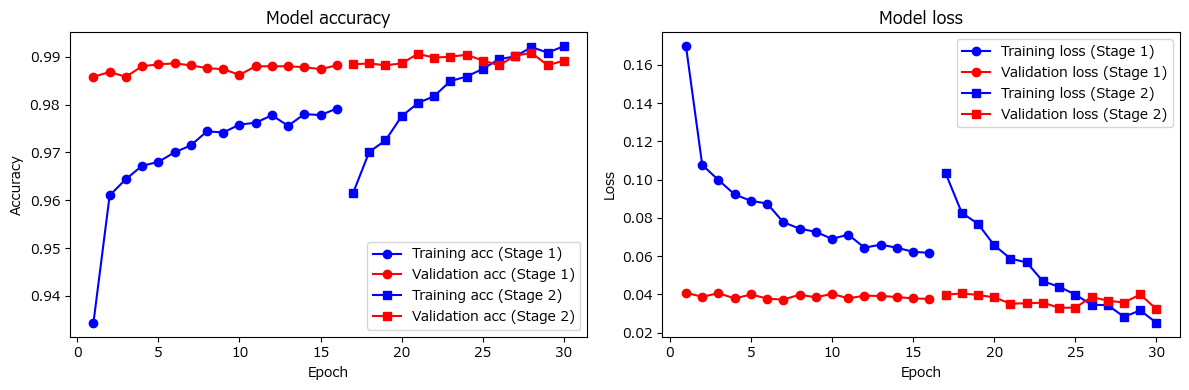

5000/5000 [==============================] - 40s 8ms/step
▶ classification_results.csv に書き出しましたにゃ！


In [5]:
# 📊 学習結果の可視化
import matplotlib.pyplot as plt
# フォント設定（例：Windows + メイリオ）
plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['axes.unicode_minus'] = False

def plot_training_history(history_1, history_2=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # 精度のプロット
    epochs_1 = range(1, len(history_1.history['accuracy']) + 1)
    ax1.plot(epochs_1, history_1.history['accuracy'], 'bo-', label='Training acc (Stage 1)')
    ax1.plot(epochs_1, history_1.history['val_accuracy'], 'ro-', label='Validation acc (Stage 1)')
    
    if history_2:
        epochs_2 = range(len(epochs_1) + 1, len(epochs_1) + len(history_2.history['accuracy']) + 1)
        ax1.plot(epochs_2, history_2.history['accuracy'], 'bs-', label='Training acc (Stage 2)')
        ax1.plot(epochs_2, history_2.history['val_accuracy'], 'rs-', label='Validation acc (Stage 2)')
    
    ax1.set_title('Model accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # 損失のプロット
    ax2.plot(epochs_1, history_1.history['loss'], 'bo-', label='Training loss (Stage 1)')
    ax2.plot(epochs_1, history_1.history['val_loss'], 'ro-', label='Validation loss (Stage 1)')
    
    if history_2:
        ax2.plot(epochs_2, history_2.history['loss'], 'bs-', label='Training loss (Stage 2)')
        ax2.plot(epochs_2, history_2.history['val_loss'], 'rs-', label='Validation loss (Stage 2)')
    
    ax2.set_title('Model loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# グラフを表示
plot_training_history(history_1, history_2)

# 6. 予測結果を CSV に出力
import pandas as pd
preds       = model.predict(val_gen, steps=len(val_gen), verbose=1)
pred_labels = (preds >= 0.5).astype(int).flatten()
true_labels = val_gen.classes
filenames   = val_gen.filenames

df = pd.DataFrame({
    'filename': filenames,
    'true':     true_labels,
    'pred':     pred_labels
})
df.attrs['param'] = {'epoch':EPOCHS, 'batch':BATCH_SIZE,
                     'lr':1e-4, 'aug':'std'}
df['correct'] = df['true'] == df['pred']
df.to_csv('classification_results.csv', index=False)
print("▶ classification_results.csv に書き出しましたにゃ！")
